In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import probplot

import sys
sys.path.append("../")

from electronfactors.model.utilities import *


In [3]:
from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'16'})
rc('text', usetex=True)

In [4]:
def create_histogram(data):
    plt.figure(figsize=(6 * 1.618, 6))
    
    bins = np.arange(-1.5, 2, 0.5)
    dbins = bins[1] - bins[0]
    binsTrans = bins - dbins/2

    binsTrans = binsTrans.reshape(-1,1)
    binNum = np.argmin(abs(binsTrans - data),0)

    representative_height = np.zeros(len(binNum))

    for i in range(len(bins)):
        binRef = (binNum == i)
        representative_height[binRef] = np.arange(sum(binRef)) + 1

    plt.hist(data, bins, alpha=0.6, lw=2)
    plt.scatter(data, representative_height, zorder=2, s=120, alpha=0.8, lw=1.5)
    
    uncertainty = estimate_population_uncertainty(data)
    
    print("Mean = %0.2f" % (np.mean(data)))
    print("Uncertainty = %0.2f" % (uncertainty))

In [29]:
def display_fit(width, eqPonA, factor, model):
    plt.figure(figsize=(6 * 1.618, 6))
    x = np.arange(np.floor(np.min(width)) - 0.5, np.ceil(np.max(width)) + 0.5, 0.05)
    y = np.arange(np.floor(np.min(eqPonA)*10)/10 - 0.2, np.ceil(np.max(eqPonA)*10)/10 + 0.2, 0.005)

    xx, yy = np.meshgrid(x, y)

    zz = model(xx, yy)
    give = fit_give(xx, yy, width, eqPonA, factor, kx=2, ky=1)

    outOfTolerance = (give > 0.5)

    zz[outOfTolerance] = np.nan

    c = plt.contourf(xx, yy, zz, 100, alpha=1)
    plt.colorbar(c)

    plt.contour(xx, yy, give, levels=[0.5], colors='g')

    plt.scatter(width, eqPonA, s=45, alpha=0.9, zorder=3)

    plt.xlabel(r'Width (cm)')
    plt.ylabel(r'Perimeter / Area (cm$^{-1}$)')
    plt.title(r'Bivariate spline fit')

In [5]:
width, length, eqPonA, factor = pull_data(energy=12)

In [26]:
mean_true = {}
mean_predict = {}
uncert_true = {}
uncert_predict = {}

# test = [8, 12, 15, 20]
test = [15]

for amount in test:
    mean_true[amount] = np.array([])
    mean_predict[amount] = np.array([])

    uncert_true[amount] = np.array([])
    uncert_predict[amount] = np.array([])

In [41]:
for amount in test:
    for j in range(100):
        order = np.arange(len(width))
        np.random.shuffle(order)
        reference = order[0:amount]
        reference
        check = np.setdiff1d(np.arange(len(width)), reference)
        check
        give = np.zeros(len(check))
        predictions = np.zeros(len(check))

        model = create_model(width[reference], eqPonA[reference], factor[reference])

        for i, value in enumerate(check):
            predictions[i] = model(width[value], eqPonA[value])
            give[i] = fit_give(
                width[value], eqPonA[value], 
                width[reference], eqPonA[reference], factor[reference])

        valid = give < 0.5
        predicted_percent_differences = calculate_percent_prediction_differences(
                width[reference], eqPonA[reference], factor[reference])
        
        if (np.sum(valid) > 3) & (len(predicted_percent_differences) > 3):
        
            percent_prediction_differences = 100*(factor[check] - predictions) / factor[check]
            

            mean_true[amount] = np.append(
                mean_true[amount],
                np.mean(percent_prediction_differences))
            mean_predict[amount] = np.append(
                mean_predict[amount],
                np.mean(predicted_percent_differences))

            uncert_true[amount] = np.append(
                uncert_true[amount],
                estimate_population_uncertainty(percent_prediction_differences))
            uncert_predict[amount] = np.append(
                uncert_predict[amount],
                estimate_population_uncertainty(predicted_percent_differences))
            
            check_for_bad_set = (
                (np.abs(np.mean(percent_prediction_differences)) + 
                estimate_population_uncertainty(percent_prediction_differences)) -
                (np.abs(np.mean(predicted_percent_differences)) + 
                estimate_population_uncertainty(predicted_percent_differences))
            )
            
            if np.abs(check_for_bad_set) > 2:
                print( repr(np.array(reference)) )

array([12, 42, 17, 44, 32, 30, 39,  2, 16, 38, 25, 27, 31,  7, 29])


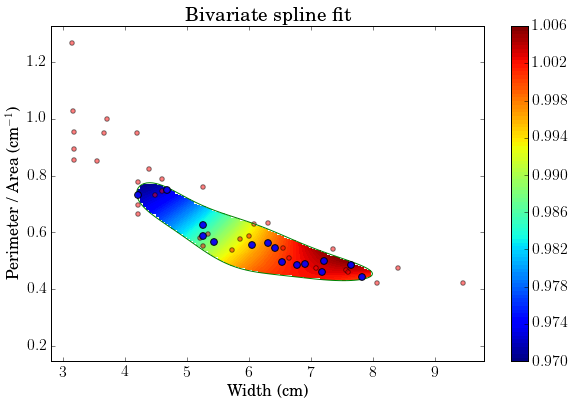

In [42]:
reference = [12, 42, 17, 44, 32, 30, 39,  2, 16, 38, 25, 27, 31,  7, 29]

model = create_model(width[reference], eqPonA[reference], factor[reference])
display_fit(width[reference], eqPonA[reference], factor[reference], model)
plt.scatter(width, eqPonA, c='red', alpha=0.5)

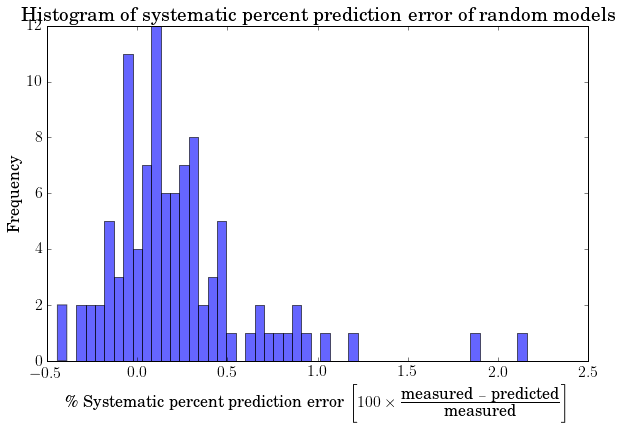

In [25]:
amount = 15
plt.figure(figsize=(6 * 1.618, 6))
plt.hist(
    (np.abs(mean_true[amount]) + uncert_true[amount]) - (np.abs(mean_predict[amount]) + uncert_predict[amount]), 
    50, alpha=0.6, lw=1)

plt.xlabel(
    r'\% Systematic percent prediction error '
    r'$\left[100 \times \frac{\mbox{measured } - \mbox{ predicted}}{\mbox{measured}} \right]$')
plt.ylabel(r'Frequency')
plt.title(r'Histogram of systematic percent prediction error of random models')


In [21]:
np.abs(mean_true[amount]) + uncert_true[amount]

array([ 0.87255312,  1.06806596,  1.03337597,  0.78982906,  1.07509579,
        0.61465309,  0.87738008,  0.50010867,  3.13210633,  0.83804131,
        0.74740555,  1.00115616,  3.46823345,  0.99861277,  0.71141007,
        0.60742289,  0.64353842,  1.56654368,  0.92363843,  0.53502167,
        0.78356497,  1.35261745,  0.68494733,  0.69588772,  1.06271035,
        0.97678193,  0.47188093,  0.80647107,  0.65147595,  0.70543919,
        0.97150122,  0.77850821,  0.74902862,  1.64499239,  1.09253512,
        0.73468539,  0.69080841,  2.29927609,  0.7913772 ,  1.68034154,
        0.50324661,  0.67715261,  0.50589329,  1.11654281,  0.52811627,
        1.91733732,  1.11938761,  0.82403263,  0.83721782,  1.31251242,
        2.05556984,  0.84306092,  1.33654338,  0.95252431,  0.79115676,
        0.67990494,  2.73090868,  0.91707385,  0.91698348,  1.08060709,
        0.91445259,  0.68294092,  0.79705326,  0.68218291,  0.73417436,
        1.70109825,  0.74700227,  1.19008595,  0.63413537,  1.08

In [ ]:
amount = 12
plt.figure(figsize=(6 * 1.618, 6))
plt.hist(mean_store[amount], 50, alpha=0.6, lw=1)

plt.xlabel(
    r'\% Systematic percent prediction error '
    r'$\left[100 \times \frac{\mbox{measured } - \mbox{ predicted}}{\mbox{measured}} \right]$')
plt.ylabel(r'Frequency')
plt.title(r'Histogram of systematic percent prediction error of random models')
print(amount)
print(np.mean(mean_store[amount]))
print(estimate_population_uncertainty(mean_store[amount]))

In [ ]:
amount = 15
plt.figure(figsize=(6 * 1.618, 6))
plt.hist(mean_store[amount], 50, alpha=0.6, lw=1)

plt.xlabel(
    r'\% Systematic percent prediction error '
    r'$\left[100 \times \frac{\mbox{measured } - \mbox{ predicted}}{\mbox{measured}} \right]$')
plt.ylabel(r'Frequency')
plt.title(r'Histogram of systematic percent prediction error of random models')
print(amount)
print(np.mean(mean_store[amount]))
print(estimate_population_uncertainty(mean_store[amount]))

In [ ]:
amount = 20
plt.figure(figsize=(6 * 1.618, 6))
plt.hist(mean_store[amount], 50, alpha=0.6, lw=1)

plt.xlabel(
    r'\% Systematic percent prediction error '
    r'$\left[100 \times \frac{\mbox{measured } - \mbox{ predicted}}{\mbox{measured}} \right]$')
plt.ylabel(r'Frequency')
plt.title(r'Histogram of systematic percent prediction error of random models')
print(amount)
print(np.mean(mean_store[amount]))
print(estimate_population_uncertainty(mean_store[amount]))